In [16]:
import os
import csv
import shutil
import random

In [14]:
directoryone = "daps_Data\\Class_One\\Spectrograms"
directorytwo = "daps_Data\\Class_Two\\Spectrograms"
for filename in os.listdir(directoryone):
    if 'f10' in filename:
        fullpath = os.path.join(directoryone, filename)
        shutil.move(fullpath, directorytwo)

In [18]:
test_directory = "daps_Data\\test_dataset\\Images"
training_directory = "daps_Data\\training_dataset\\Images"
directoryone = "daps_Data\\Class_One\\Spectrograms"
directorytwo = "daps_Data\\Class_Two\\Spectrograms"
i = 1
a = random.sample(range(1, 1968), 300)
for filename in os.listdir(directoryone):
    fullpath = os.path.join(directoryone, filename)
    if i in a:
        shutil.copy(fullpath, test_directory)        
    else:
        shutil.copy(fullpath, training_directory)
    i=i+1
i=1
a = random.sample(range(1, 4464), 700)
for filename in os.listdir(directorytwo):
    fullpath = os.path.join(directorytwo, filename)
    if i in a:
        shutil.copy(fullpath, test_directory)        
    else:
        shutil.copy(fullpath, training_directory)
    i=i+1

In [22]:
# name of csv file
csvname = "daps_Data\\training_dataset\\labels.csv"
class_one_indicators = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']
directory = "daps_Data\\training_dataset\\images"
# writing to csv file
with open(csvname, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
    for filename in os.listdir(directory):
        if any(indicator in filename for indicator in class_one_indicators) and not 'f10' in filename:
            csvwriter.writerow([filename, '1'])
        else:
            csvwriter.writerow([filename, '0'])        

In [34]:
from PIL import Image
training_directory = "daps_Data\\training_dataset\\Images"
left = 125
top = 60
right = 901
bottom = 446
target = "daps_Data\\training_dataset\\Images_cropped\\"
# Opens a image in RGB mode
for filename in os.listdir(training_directory):
    fullpath = os.path.join(training_directory, filename)
    im = Image.open(fullpath)
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
# width, height = im.size
 
# Setting the points for cropped image

 
# Cropped image of above dimension
# (It will not change original image)
    im1 = im.crop((left, top, right, bottom))
    im1.save(target + filename)
# Shows the image in image viewer


In [3]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [6]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
import torch
import torchvision
import torchvision.transforms.v2
import torchvision.transforms as transforms

In [8]:
transform = torchvision.transforms.v2.Compose([transforms.v2.ToImage(), transforms.v2.ToDtype(torch.float32, scale=True),\
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = ImageDataset(annotations_file = "daps_Data\\training_dataset\\labels.csv", img_dir = "daps_Data\\training_dataset\\Images_cropped")

testset = ImageDataset(annotations_file = "daps_Data\\test_dataset\\labels.csv", img_dir = "daps_Data\\test_dataset\\Images_cropped")

In [9]:
batch_size = 4

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ("0", "1")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..127.5].


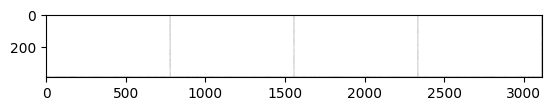

0     0     0     0    


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output


net = Net()
print(net)

NameError: name 'nn' is not defined

In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [43]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: 